#### 이번 프로젝트는 NLP기반인 인공지능을 만드는 것으로
인간이 갖고 있던 고유한 언어적 특성을 인공지능이 얼마나 구현하고 수행하고 있는지에 대해서  알 수 있었다.

## 프로젝트 속 CS

1.시퀀스

-정의 : 순서가 있는 데이터 구조  입니다.

-종류 : 리스트, 튜플,기타 등등

i)리스트

:다양한 데이터를 담을 수 있고 데이터 변경도 가능

:대괄호([,])로 표현

:값을 변경할 수 있는 가변 데이터

ii)튜플

:다양한 데이터를 담을 순 있으나 데이터는 변경안됨.

:소괄호()로 표현

:불변 데이터

2.순환신경망(RNN)

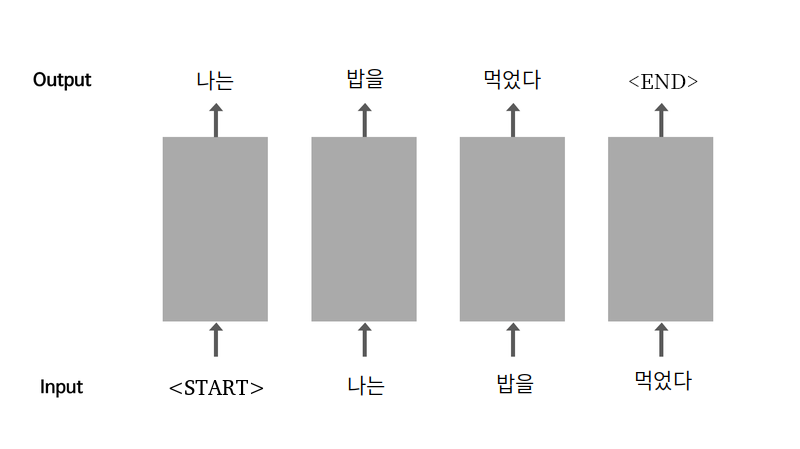

:특수 토큰(START)를 통해서 많은 데이터를 처리하고 생성한 단어를 다시 입력으로 사용한다.


3.언어 모델(Language Model)

: n-1개의 단어가 있을 때, 그 다음 순서인 n번째에 어떤 단어가 올지 예측을 하는 확률 모델입니다.

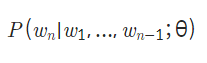


모델 학습 
-n-1 번째까지의 단어 시퀀스 : x_train
-n번째 단어: y_train

## 데이터 전처리 과정

1.소스 문장(Source Sentence)

:모델의 입력이 되는 문장

2.타겟 문장(Target Sentence)

:모델의 출력 문장

3.벡터화(vectorize)

tf.keras.preprocessing.text.Tokenizer패키지 이용
-> 정제된 데이터 토큰화를 통해서 단어 사전을 만들어 주고 이로 인해 데이터를 숫자로 변환 시킴.

4.텐서(tensor)

:숫자로 변환된 데이터

5.정규표현식을 통해 corpus생성

6.tf.keras.preprocessing.text.Tokenizer
:corpus를 텐서로 변환

7.tf.data.Dataset.from_tensor_slices

:corpus텐서-> tf.data.Dataset객체로 변화

## 인공지능 모델

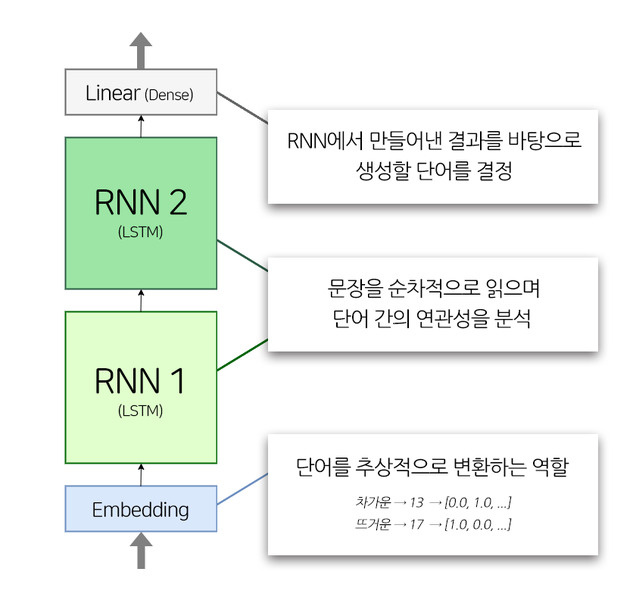

1.모델 만든 방식

:tf.keras.Model을 Subclassing하는 방식.

2.모델 구성 방식

Embedding -1개

:인덱스 값을 해당 인덱스 번째의 워드 벡터(추상적 표현으로 사용이 됨)

embedding_size: 워드 벡터의 차원 수

ex)

차갑다: [0.0, 1.0]
뜨겁다: [1.0, 0.0]
미지근하다: [0.5, 0.5]


LSTM - 2개

:모델에 얼마나 많은 일꾼을 넣을까에 대한 물음이다.

hidden_size.

Dense - 1개


In [1]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


데이터 다듬기

In [2]:
! mkdir -p ~/aiffel/lyricist/models
! ln -s ~/data ~/aiffel/lyricist/data

In [3]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


토큰화

In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


In [5]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [6]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

In [7]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fdfd7978f10>


In [8]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-2.43312374e-04,  2.43466566e-04, -2.10082580e-05, ...,
          4.35002235e-04, -7.79913171e-06, -2.63730290e-05],
        [-7.61487754e-04,  1.82141448e-04, -3.27250309e-04, ...,
          4.56005742e-04, -1.35181645e-05,  1.62904762e-04],
        [-1.10108859e-03,  3.06096685e-04, -3.96574673e-04, ...,
          7.21021148e-04,  2.25041105e-04,  4.65569290e-04],
        ...,
        [ 1.03177025e-03, -3.67060711e-04,  1.92328589e-03, ...,
          1.52395529e-04, -1.25180275e-04, -9.85539373e-05],
        [ 1.37106003e-03, -5.26004762e-04,  2.56412011e-03, ...,
         -3.44176333e-05, -6.54719770e-04, -8.87183298e-04],
        [ 1.72463711e-03, -6.69147470e-04,  3.17722023e-03, ...,
         -1.21965066e-04, -1.17174548e-03, -1.64608611e-03]],

       [[-2.43312374e-04,  2.43466566e-04, -2.10082580e-05, ...,
          4.35002235e-04, -7.79913171e-06, -2.63730290e-05],
        [-3.07035982e-04,  5.19866531e-04,  4.

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 41s 408ms/step - loss: 4.3851
Epoch 2/30
93/93 [==============================] - 33s 360ms/step - loss: 2.8141
Epoch 3/30
93/93 [==============================] - 33s 360ms/step - loss: 2.7357
Epoch 4/30
93/93 [==============================] - 34s 361ms/step - loss: 2.6451
Epoch 5/30
93/93 [==============================] - 34s 362ms/step - loss: 2.5657
Epoch 6/30
93/93 [==============================] - 34s 362ms/step - loss: 2.5097
Epoch 7/30
93/93 [==============================] - 34s 362ms/step - loss: 2.4648
Epoch 8/30
93/93 [==============================] - 34s 362ms/step - loss: 2.4047
Epoch 9/30
93/93 [==============================] - 34s 362ms/step - loss: 2.3566
Epoch 10/30
93/93 [==============================] - 34s 362ms/step - loss: 2.3210
Epoch 11/30
93/93 [==============================] - 34s 362ms/step - loss: 2.2802
Epoch 12/30
93/93 [==============================] - 34s 362ms/step - loss: 2.2362
Epoch 13/30
9

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [17]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he is a <unk> , and i am not so <end> '